In [ ]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# import numpy as np

In [ ]:
# def g2(x, coefficients):
# 		sumOfValue = 0
# 		for i, co in enumerate(coefficients):
# 			sumOfValue += co * (x ** (len(coefficients)-i-1))
# 		return sumOfValue

In [ ]:
# # 몇 차까지 할건가요?
# nthLimit = 4

# # x 범위는요? ()
# xRange = np.arange(0, 10, 0.1)

# # 그 중에 몇 점을 뽑을건가요?
# wantToPick = 10

# # 데이터 생성 개수 (1차 당)
# wantToProduce = 1

In [ ]:
# dataX = []
# dataY = []
# for nth in range(1, nthLimit):
#     for _ in range(wantToProduce):
#         dataXtmp = [nth] # n차 정보 심어줌

#         pick = np.sort(np.random.choice(xRange, wantToPick))
#         co = np.random.rand(nth)
#         yTmp = {x : g2(x, co) for x in xRange}
#         for k in pick:
#             dataXtmp.append(k) # 데이터 심어줌
#             dataXtmp.append(yTmp[k]) # 데이터 심어줌
#         dataYtmp = [yTmp[k] for k in pick]
#         dataX.append(dataXtmp)
#         dataY.append(dataYtmp)
# dataX = np.array(dataX)
# dataY = np.array(dataY)

In [ ]:
# len(dataX), len(dataY)

(30000, 30000)

미리 생성은 별로다 generator 써보자

In [72]:
import numpy as np

class PolynomialDataGenerator:
    def __init__(self, nth_limit, x_range, want_to_pick, batch_size):
        """
        다항식 데이터를 실시간으로 생성하는 클래스

        Parameters:
        - nth_limit: 다항식 차수의 상한 (최대 n차)
        - x_range: x 값의 범위 (예: np.arange(0, 10, 0.1))
        - want_to_pick: 사용할 데이터 포인트 개수
        - batch_size: 한 번에 생성할 배치 크기
        """
        self.nth_limit = nth_limit
        self.x_range = x_range
        self.want_to_pick = want_to_pick
        self.batch_size = batch_size

    def g2(self, x, coefficients):
        """다항식 계산 함수"""
        sum_of_value = 0
        for i, co in enumerate(coefficients):
            sum_of_value += co * (x ** (len(coefficients) - i - 1))
        return sum_of_value

    def generate_batch(self):
        """한 배치 데이터 생성"""
        dataX = []
        dataY = []
        for _ in range(self.batch_size):
            nth = np.random.randint(1, self.nth_limit)  # 1차부터 nth_limit-1차까지 랜덤 선택
            dataXtmp = [nth]  # n차 정보 추가

            # x 값 샘플링 및 정렬
            pick = np.sort(np.random.choice(self.x_range, self.want_to_pick, replace=False))

            # 다항식 계수 생성
            coefficients = np.random.rand(nth)

            # y 값 계산
            yTmp = {x: self.g2(x, coefficients) for x in self.x_range}

            # 선택된 x와 해당 y 값을 입력 데이터에 추가
            for k in pick:
                dataXtmp.append(k)         # x 값 추가
                dataXtmp.append(yTmp[k])  # y 값 추가

            # 전체 x_range에 대한 y 값을 타겟 데이터로 설정
            dataYtmp = [yTmp[k] for k in self.x_range]

            dataX.append(dataXtmp)
            dataY.append(dataYtmp)

        return np.array(dataX), np.array(dataY)

    def __iter__(self):
        """제너레이터 방식으로 데이터를 반환"""
        while True:
            yield self.generate_batch()


In [73]:
nth_limit = 4
x_range = np.arange(0, 10, 0.1)
want_to_pick = 10
batch_size = 32

# 데이터 생성기 인스턴스 생성
data_gen = PolynomialDataGenerator(nth_limit, x_range, want_to_pick, batch_size)


In [74]:
x_batch, y_batch = next(iter(data_gen))
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)


x_batch shape: (32, 21)
y_batch shape: (32, 100)


In [112]:
import tensorflow as tf

# TensorFlow Dataset으로 변환
dataset = tf.data.Dataset.from_generator(
    lambda: data_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 2 * want_to_pick + 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(x_range)), dtype=tf.float32)
    )
)

# 모델 정의 및 학습
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(x_range))  # x_range 전체 길이만큼 출력
])
model.compile(optimizer='adam', loss='mse')


In [113]:
model.build((None, 2 * want_to_pick + 1))  # 입력 데이터의 형태 (배치 크기 x 입력 크기)
model.summary()  # 모델 구조를 확인

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               2816      
                                                                 
 dense_20 (Dense)            (None, 100)               12900     
                                                                 
Total params: 15716 (61.39 KB)
Trainable params: 15716 (61.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [118]:
model.fit(dataset, epochs=1, steps_per_epoch=1000)

1000/1000 [==============================] - 10s 10ms/step - loss: 0.1376


In [119]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 47ms/step


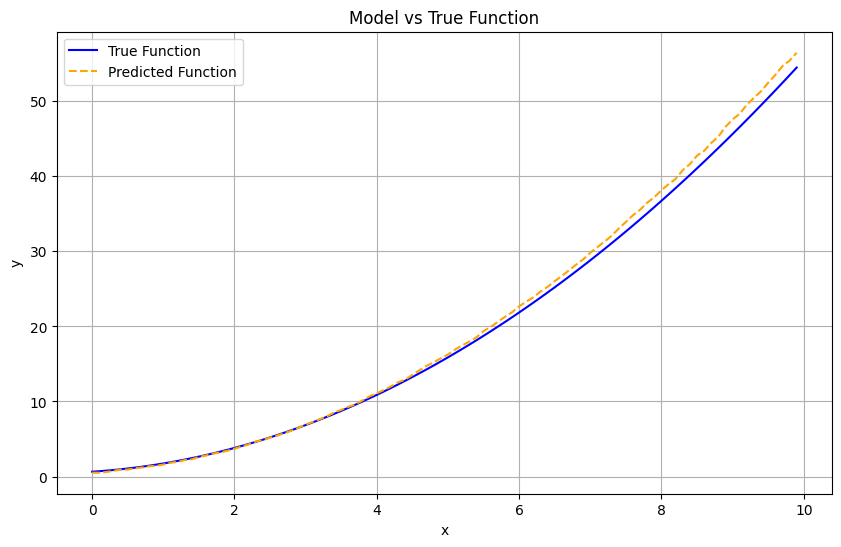

In [120]:
# 테스트 데이터 생성
test_gen = iter(data_gen)
x_test, y_test = next(test_gen)

# 모델 예측
y_pred = model.predict(x_test)

# 시각화
def plot_prediction(x_range, y_true, y_pred, title="Model Prediction"):
    plt.figure(figsize=(10, 6))
    plt.plot(x_range, y_true[0], label="True Function", color="blue")
    plt.plot(x_range, y_pred[0], label="Predicted Function", color="orange", linestyle="--")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid()
    plt.show()

# 그래프 출력
plot_prediction(x_range, y_test, y_pred, title="Model vs True Function")

1/1 [==============================] - 0s 22ms/step


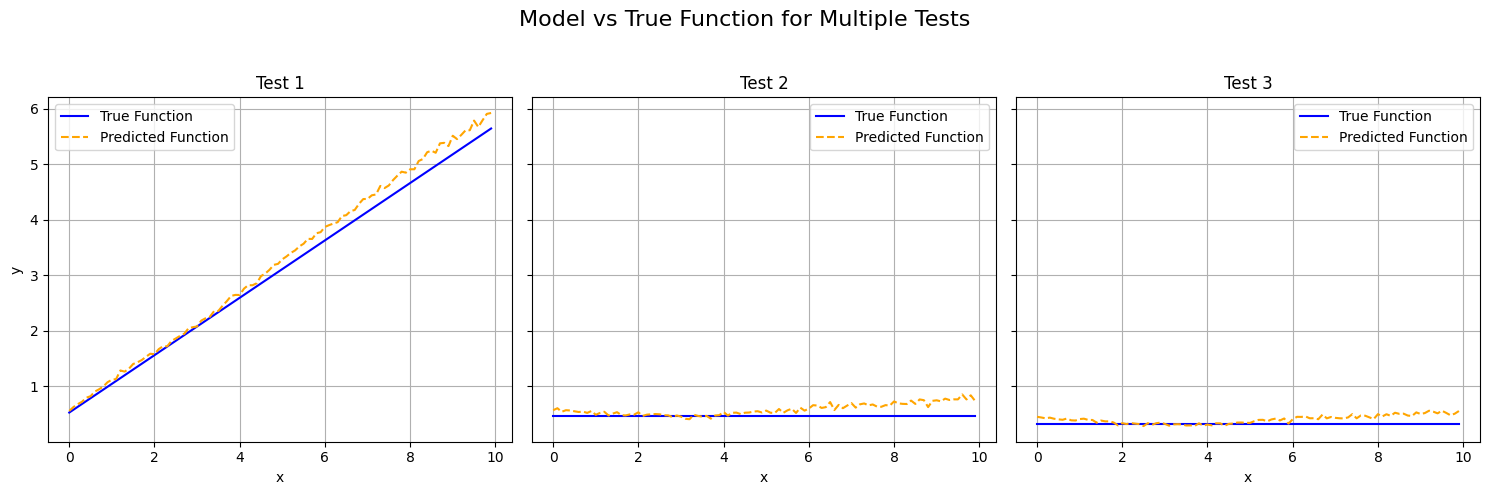

In [121]:
# 테스트 데이터 생성 및 예측
num_tests = 3
test_results = []

for _ in range(num_tests):
    x_test, y_test = next(iter(data_gen))  # 테스트 데이터 생성
    y_pred = model.predict(x_test)        # 모델 예측
    test_results.append((x_test, y_test, y_pred))

# 시각화 함수: 여러 테스트 결과를 출력
def plot_multiple_predictions(x_range, test_results, title="Model Predictions"):
    num_tests = len(test_results)
    fig, axes = plt.subplots(1, num_tests, figsize=(5 * num_tests, 5), sharey=True)

    if num_tests == 1:  # 테스트 결과가 1개인 경우 처리
        axes = [axes]

    for i, (x_test, y_true, y_pred) in enumerate(test_results):
        axes[i].plot(x_range, y_true[0], label="True Function", color="blue")
        axes[i].plot(x_range, y_pred[0], label="Predicted Function", color="orange", linestyle="--")
        axes[i].set_title(f"Test {i+1}")
        axes[i].set_xlabel("x")
        if i == 0:  # 첫 번째 플롯만 y 축 라벨 추가
            axes[i].set_ylabel("y")
        axes[i].legend()
        axes[i].grid()

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 그래프 출력
plot_multiple_predictions(x_range, test_results, title="Model vs True Function for Multiple Tests")
